In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from tqdm import tqdm
import statistics

In [2]:
import random
random.seed(2021)
torch.manual_seed(2021)
np.random.seed(2021)

In [3]:
df=pd.read_csv("D:\Transformer_thesis\Dataset\V_228.csv",header=None)  

In [4]:
#!cat /proc/meminfo

In [5]:
df=df.iloc[:,:5]

In [6]:
df.shape

(12672, 5)

In [7]:
#data=df.iloc[:,:5].values

In [8]:
data=df.values

In [9]:
data.shape

(12672, 5)

In [10]:
def train_test_split(data):

   test_size=1440
   validation_size=1440
   train_data=data[:-test_size - validation_size]

   validation_data=data[-test_size - validation_size:-test_size]
   test_data=data[-test_size:]
   return train_data,validation_data,test_data

In [11]:
def create_train_sequences(data,window_size,forecast_horizon):
  #X=[]
  #y=[]
  X_shape=[(len(data)-window_size-forecast_horizon + 1),window_size]

  y_shape=[(len(data)-window_size-forecast_horizon + 1),forecast_horizon]
  X=np.zeros(X_shape)
  y=np.zeros(y_shape)
  for i in range(len(data)-window_size- forecast_horizon + 1):
        _x = data[i:(i+window_size)]
        #_y = data[i+window_size]
        _y=data[i + window_size:i + window_size + forecast_horizon]
        X[i,:]=_x
        y[i,:]=_y


  return X,y

In [12]:
def create_test_sequences(data, window_size, forecast_horizon):

    num_samples = len(data) // (window_size + forecast_horizon)
    X_shape = (num_samples, window_size)
    y_shape = (num_samples, forecast_horizon)
    X = np.zeros(X_shape)
    y = np.zeros(y_shape)

    for i in range(num_samples):
        start_index = i * (window_size + forecast_horizon)
        end_index_x = start_index + window_size
        end_index_y = end_index_x + forecast_horizon

        _x = data[start_index:end_index_x]
        _y = data[end_index_x:end_index_y]

        X[i, :] = _x
        y[i, :] = _y

    return X, y

In [13]:
window_size=12
context_window=120

def create_attention_seq(data,window_size,forecast_horizon,context_window):
  X_attention=[]
  end_index=0
  for i in range(len(data)-window_size- forecast_horizon + 1):
      if end_index < context_window:
         _x=data[0:window_size+i]
         end_index=window_size+i
         zeros_to_add=[0]*(context_window - len(_x))
         _x = pd.concat([ pd.Series(zeros_to_add),_x],ignore_index=True)
      else:
         _x=data[window_size+i-context_window-1:window_size+i-1]
      X_attention.append(_x)
  return X_attention



In [14]:
def create_attention_test_sequences(data, window_size, forecast_horizon,context_window):
   
    X_attention=np.zeros((len(data),context_window))
    
    for i in range(len(test_x)):
        
        if(i<=int(context_window/sequence_length - 2)):       
            subset_x=data[0:i+1]
            X_attention[i]=np.concatenate ((np.zeros( sequence_length*((int(context_window/sequence_length)) - (i+1)) ), subset_x.reshape(-1)))   
        else:
            start_index=int(i-((context_window/sequence_length)-1))
            X_attention[i]=data[start_index:i+1].reshape(-1) 
     
    return X_attention
    

In [15]:
"""
def create_test_sequences(data, window_size, forecast_horizon):

    X_shape=[(len(data)-window_size- forecast_horizon + 1),window_size]
    y_shape=[(len(data)-window_size- forecast_horizon + 1),forecast_horizon]
    X=np.zeros(X_shape)
    y=np.zeros(y_shape)
    step_size = window_size + forecast_horizon

    for i in range(0, len(data) - window_size - forecast_horizon + 1, step_size):
        _x = data[i:(i + window_size)]
        _y = data[i + window_size:i + window_size + forecast_horizon]
        X[i,:]=_x
        y[i,:]=_y

    return X, y
"""

'\ndef create_test_sequences(data, window_size, forecast_horizon):\n\n    X_shape=[(len(data)-window_size- forecast_horizon + 1),window_size]\n    y_shape=[(len(data)-window_size- forecast_horizon + 1),forecast_horizon]\n    X=np.zeros(X_shape)\n    y=np.zeros(y_shape)\n    step_size = window_size + forecast_horizon\n\n    for i in range(0, len(data) - window_size - forecast_horizon + 1, step_size):\n        _x = data[i:(i + window_size)]\n        _y = data[i + window_size:i + window_size + forecast_horizon]\n        X[i,:]=_x\n        y[i,:]=_y\n\n    return X, y\n'

In [16]:
#sc=MinMaxScaler()
#df_scaled=sc.fit_transform(data)

In [17]:
#df_scaled.shape

In [18]:
sequence_length=12
horizon=9
batch_size=32
input_size=1
hidden_size=64
output_size=1
ff_hiddensize=64
mask_flag=None
attn_head=8
start_dec_token_len=6
test_size=1440
validation_size=1440

In [19]:
df.iloc[:,0]

0        71.1
1        68.1
2        68.0
3        68.3
4        68.9
         ... 
12667    70.3
12668    69.9
12669    68.9
12670    69.2
12671    68.6
Name: 0, Length: 12672, dtype: float64

In [20]:
train_seq_x=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , sequence_length ])
train_seq_y=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , horizon])
train_attention_x=np.zeros([df.shape[1], ((len(df)-validation_size-test_size-sequence_length-horizon+1)), context_window])

valid_seq_x=np.zeros([df.shape[1], validation_size-sequence_length-horizon+1  , sequence_length ])
valid_seq_y=np.zeros([df.shape[1], validation_size-sequence_length-horizon+1 , horizon ])
valid_attention_x=np.zeros([df.shape[1],  validation_size-sequence_length-horizon+1, context_window])

test_seq_x=np.zeros([df.shape[1], test_size // (sequence_length + horizon), sequence_length ])
test_seq_y=np.zeros([df.shape[1],  test_size // (sequence_length + horizon) , horizon])
test_attention_x=np.zeros([df.shape[1], test_size // (sequence_length + horizon)  , context_window])

for i in range(df.shape[1]):
  train_data,validation_data,test_data = train_test_split(df.iloc[:,i])
  #print(train_data.shape)
  #break

  train_x,train_y=create_train_sequences(train_data,sequence_length,horizon)

  train_seq_x[i,:,:]=train_x
  train_seq_y[i,:,:]=train_y
  #train_seq_x.append(train_x)
  #train_seq_y.append(train_y)

  train_attention_x[i,:,:]=create_attention_seq(train_data,window_size, horizon,context_window)

  valid_x,valid_y=create_train_sequences(validation_data,sequence_length,horizon)
  valid_seq_x[i,:,:]=valid_x
  valid_seq_y[i,:,:]=valid_y
  #valid_seq_x.append(valid_x)
  #valid_seq_y.append(valid_y)

  valid_attention_x[i,:,:]=create_attention_seq(validation_data,window_size, horizon,context_window)

  test_x,test_y=create_test_sequences(test_data,sequence_length,horizon)
  test_seq_x[i,:,:]=test_x
  test_seq_y[i,:,:]=test_y
  
  test_attention_x[i,:,:]=create_attention_test_sequences(test_x,window_size, horizon,context_window)
  
  #test_seq_x.append(test_x)
  #test_seq_y.append(test_y)

  #test_x=create_attention_test_sequences(test_data,window_size, horizon,context_window)
  #test_attention_x[i,:,:]=test_x

<ipython-input-13-4e134ed9f395>:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _x = pd.concat([ pd.Series(zeros_to_add),_x],ignore_index=True)
<ipython-input-11-899fa6672d57>:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  _x = data[i:(i+window_size)]
<ipython-input-11-899fa6672d57>:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  _y=data[i + window_size:i + 

In [21]:
X_train=torch.tensor(train_seq_x,dtype=torch.float32)
y_train=torch.tensor(train_seq_y,dtype=torch.float32)
X_valid=torch.tensor(valid_seq_x,dtype=torch.float32)
y_valid=torch.tensor(valid_seq_y,dtype=torch.float32)
X_test=torch.tensor(test_seq_x,dtype=torch.float32)
y_test=torch.tensor(test_seq_y,dtype=torch.float32)
X_train_attention=torch.tensor(train_attention_x,dtype=torch.float32)
X_valid_attention=torch.tensor(valid_attention_x,dtype=torch.float32)
X_test_attention=torch.tensor(test_attention_x,dtype=torch.float32)

In [22]:
X_test_attention.shape,X_test.shape,X_valid.shape,train_attention_x.shape

(torch.Size([5, 68, 120]),
 torch.Size([5, 68, 12]),
 torch.Size([5, 1420, 12]),
 (5, 9772, 120))

In [1]:
#train_seq_x[0,131,:],train_attention_x[0,120,:]

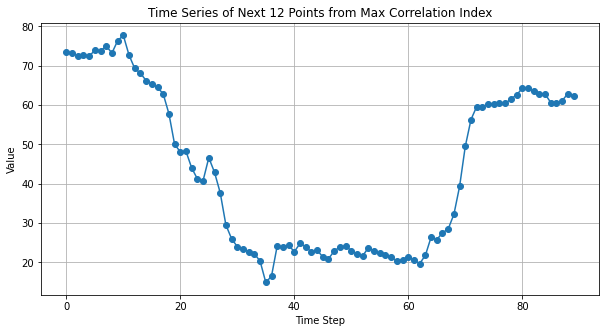

In [24]:

#def normalize(sequence):
#    return (sequence - np.mean(sequence)) / np.std(sequence)

###

#Calculate autocorrelation attention by taking a sequence_window(12) and sliding it over a context_window(120)
#Take the point where there is highest autocorrelation 
###


def autocorrelation(seq_win,con_win):
    #seq_win_norm=normalize(seq_win)
    #con_win_norm=normalize(con_win)
    corr=np.correlate(con_win,seq_win,mode="valid")
    return corr

seq_data=train_seq_x[0,151,:]
horizon_data=train_seq_y[0,151,:]
context_data=train_attention_x[0,140,:]
context_window=120
correlation=[]
for i in range(context_window-sequence_length):
    sequence_window=seq_data
    context_window_data=context_data[i:i+12] 
    corr=autocorrelation(sequence_window,context_window_data.reshape(-1)) 
    correlation.append(corr)
#print(f"Max corr: {max(correlation)} index:{np.argmax(correlation)} ")
max_correlation=max(correlation)
max_correlation_index=np.argmax(correlation)

max_correlation_seq=context_data[max_correlation_index:]
#print(f"context_data:{context_data}  max_correlation_seq:{max_correlation_seq}")
plt.figure(figsize=(10, 5))
plt.plot(max_correlation_seq, marker='o')
plt.title('Time Series of Next 12 Points from Max Correlation Index')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()


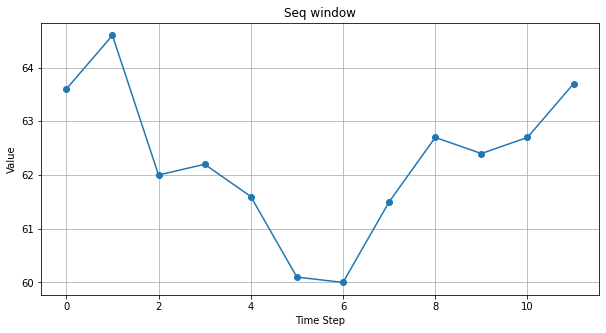

In [25]:

plt.figure(figsize=(10, 5))
plt.plot(seq_data, marker='o')
plt.title('Seq window')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()


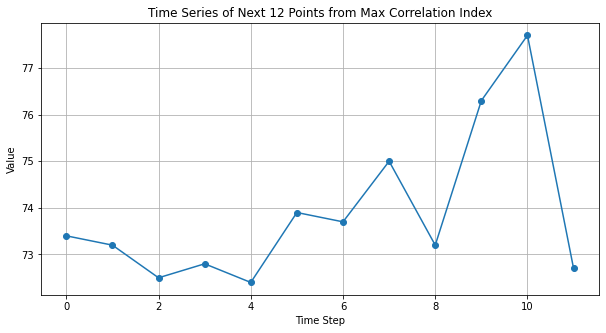

In [26]:

plt.figure(figsize=(10, 5))
plt.plot(context_data[max_correlation_index:max_correlation_index+12], marker='o')
plt.title('Time Series of Next 12 Points from Max Correlation Index')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [27]:
#Context_window data, sequence_data and horizon
context_data,seq_data,horizon_data

(array([68.9, 69.4, 68.4, 70.1, 70.3, 66.2, 66. , 67.4, 64. , 66.3, 66. ,
        70.3, 69.2, 69.4, 71.5, 68.3, 70. , 64.9, 65.4, 64.6, 66.1, 65.8,
        65.9, 67.1, 70.7, 70.6, 68.7, 69.1, 71.2, 71. , 73.4, 73.2, 72.5,
        72.8, 72.4, 73.9, 73.7, 75. , 73.2, 76.3, 77.7, 72.7, 69.3, 68.1,
        66.2, 65.4, 64.5, 62.8, 57.8, 50. , 48.1, 48.2, 44. , 41.2, 40.8,
        46.6, 42.9, 37.7, 29.5, 26. , 24. , 23.5, 22.7, 22.2, 20.3, 14.9,
        16.5, 24.2, 23.8, 24.4, 22.7, 24.8, 24. , 22.6, 23.1, 21.4, 20.9,
        22.9, 23.9, 24.1, 23. , 22.1, 21.7, 23.7, 22.9, 22.3, 21.8, 21.3,
        20.3, 20.7, 21.3, 20.6, 19.7, 21.8, 26.4, 25.8, 27.5, 28.5, 32.2,
        39.3, 49.5, 56.3, 59.6, 59.6, 60.2, 60.3, 60.4, 60.4, 61.5, 62.6,
        64.2, 64.2, 63.5, 62.8, 62.8, 60.6, 60.5, 61.1, 62.9, 62.4]),
 array([63.6, 64.6, 62. , 62.2, 61.6, 60.1, 60. , 61.5, 62.7, 62.4, 62.7,
        63.7]),
 array([65.8, 63.5, 64. , 62.1, 63.2, 62.8, 61.9, 61.7, 63.5]))

In [28]:
#data where max correlation was found, printing next 12 points from the max correlation
context_data[max_correlation_index:max_correlation_index+12] 

array([73.4, 73.2, 72.5, 72.8, 72.4, 73.9, 73.7, 75. , 73.2, 76.3, 77.7,
       72.7])

In [29]:
max_correlation_index

30

In [30]:
#context_data[59:59+12] 

In [31]:

context_window_data=np.concatenate((context_data,seq_data),axis=0)
X_context_attention=torch.tensor(context_window_data,dtype=torch.float32) 
X_context_attention=X_context_attention.reshape(1,len(context_window_data),1)

X_seq=torch.tensor(seq_data,dtype=torch.float32)
Y_horizon=torch.tensor(horizon_data,dtype=torch.float32) 


In [32]:

X_seq=X_seq.reshape(1,sequence_length,1)
Y_horizon=Y_horizon.reshape(1,horizon,1)


In [33]:
#X_seq.shape,Y_horizon.shape

In [34]:
X_train=X_train.unsqueeze(-1)
X_train=X_train.view(-1,X_train.size(2),X_train.size(3))

y_train=y_train.unsqueeze(-1)
y_train=y_train.view(-1,y_train.size(2),y_train.size(3))

X_valid=X_valid.unsqueeze(-1)
X_valid=X_valid.view(-1,X_valid.size(2),X_valid.size(3))

y_valid=y_valid.unsqueeze(-1)
y_valid=y_valid.view(-1,y_valid.size(2),y_valid.size(3))

X_test=X_test.unsqueeze(-1)
y_test=y_test.unsqueeze(-1)

X_train_attention=X_train_attention.unsqueeze(-1)
X_train_attention=X_train_attention.view(-1,X_train_attention.size(-2),X_train_attention.size(3))

X_valid_attention=X_valid_attention.unsqueeze(-1)
X_valid_attention=X_valid_attention.view(-1,X_valid_attention.size(-2),X_valid_attention.size(3))

X_test_attention=X_test_attention.unsqueeze(-1)
#X_test_attention=X_test_attention.view(-1,X_test_attention.size(-2),X_test_attention.size(3))

"""
X_test=X_test.unsqueeze(-1)
X_test=X_test.view(-1,X_test.size(2),X_test.size(3))

y_test=y_test.unsqueeze(-1)
y_test=y_test.view(-1,y_test.size(2),y_test.size(3))
"""

'\nX_test=X_test.unsqueeze(-1)\nX_test=X_test.view(-1,X_test.size(2),X_test.size(3))\n\ny_test=y_test.unsqueeze(-1)\ny_test=y_test.view(-1,y_test.size(2),y_test.size(3))\n'

In [35]:
class TimeseriesDataset(Dataset):
  def __init__(self,X,y):
    self.X=X
    self.y=y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [36]:
class AttentionDataset(Dataset):
  def __init__(self,X):
    self.X=X
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx]

In [37]:
train_dataset=TimeseriesDataset(X_train,y_train)
valid_dataset=TimeseriesDataset(X_valid,y_valid)
test_dataset=TimeseriesDataset(X_test,y_test)
train_attention_dataset=AttentionDataset(X_train_attention)
valid_attention_dataset=AttentionDataset(X_valid_attention)
test_attention_dataset=AttentionDataset(X_test_attention)


In [38]:

attention_X_y_dataset=TimeseriesDataset(X_seq,Y_horizon)
attention_context_window_dataset=AttentionDataset(X_context_attention) 


In [39]:
train_loader=DataLoader(train_dataset,batch_size,drop_last=True)
valid_loader=DataLoader(valid_dataset,batch_size,drop_last=True)
test_loader=DataLoader(test_dataset,batch_size,drop_last=True)

train_attention_loader=DataLoader(train_attention_dataset,batch_size,drop_last=True)
valid_attention_loader=DataLoader(valid_attention_dataset,batch_size,drop_last=True)
test_attention_loader=DataLoader(test_attention_dataset,batch_size,drop_last=True)


In [40]:

attention_data_loader=DataLoader(attention_X_y_dataset,drop_last=True)
attention_context_loader=DataLoader(attention_context_window_dataset,drop_last=True)


In [41]:
class InputEmbedding(nn.Module):
  def __init__(self,input_size,hidden_size):
      super().__init__()
      self.input_size=input_size
      self.hidden_size=hidden_size
      self.conv1d=nn.Conv1d(in_channels=self.input_size,out_channels=self.hidden_size,padding=1,kernel_size=3,bias=False)
  def forward(self,x):
      embedded_inp=self.conv1d(x.permute(0,2,1))
      return embedded_inp.transpose(1,2)


In [42]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()* -(math.log(10000.0) / d_model)).exp()
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self,x):
        return self.pe[:,:x.size(1)]

In [43]:
class CorrelationAttentionLayer(nn.Module):
  def __init__(self,attn_head,hidden_size):
    super().__init__()
    self.attn_head=attn_head
    self.hidden_size=hidden_size
    self.dropout=nn.Dropout(0.1)

    self.queries_emb=nn.Linear(hidden_size,hidden_size)
    self.keys_emb=nn.Linear(hidden_size,hidden_size)
    self.values_emb=nn.Linear(hidden_size,hidden_size)

  def forward(self,q,k,v):
    b,l,d=q.shape
    b,s,d=k.shape

    #Linear projection and creation of multiple heads
    queries=self.queries_emb(q).view(b,l,self.attn_head,-1)
    keys=self.keys_emb(k).view(b,s,self.attn_head,-1)
    values=self.values_emb(v).view(b,s,self.attn_head,-1)

    b,l,h,d=queries.shape
    b,s,h,d=values.shape

    if l > s:
            zeros = torch.zeros_like(queries[:, :(l - s), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
    else:
            values = values[:, :l, :, :]
            keys = keys[:, :l, :, :]

    top_k=4

    q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
    k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
    
    res = q_fft * torch.conj(k_fft)
    
    corr = torch.fft.irfft(res, n=l, dim=-1)
    
    mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
    top2_values, top2_indices = torch.topk(mean_value, 2, dim=1)
    print(f"top2_indices:{top2_indices}")
    #max_value, max_index = torch.max(mean_value, dim=1)
    #print(f"max_index: {max_index}")
    
    index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
    weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)

    tmp_corr = torch.softmax(weights, dim=-1)

    values=values.permute(0, 2, 3, 1).contiguous()

    tmp_values = values
    delays_agg = torch.zeros_like(values).float()

    for i in range(top_k):
        pattern = torch.roll(tmp_values, -int(index[i]), -1)
        delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, h, d, l))
    agg_seq=delays_agg.permute(0, 3, 1, 2).view(b,l,-1)
    return agg_seq[:,:sequence_length+3,:]
    

In [44]:
class Encoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size,ff_hiddensize,sequence_length):
    super().__init__()
    self.attention=attention
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=ff_hiddensize,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=ff_hiddensize,out_channels=hidden_size,kernel_size=1)
    self.linear=nn.Linear(ff_hiddensize,hidden_size)
    self.norm1=nn.LayerNorm(normalized_shape=(sequence_length,hidden_size))
    #self.norm1=nn.LayerNorm(hidden_size)
    self.activation=F.relu
    self.dropout=nn.Dropout(0.1)
  def forward(self,x,x_attn):
    #self.norm2=nn.LayerNorm(hidden_size)
    #attention_x,attention_val=self.attention(x,x,x,attention_mask=False,return_attention=True)
    
    b,l,d=x.shape
    attention_x=self.attention(x_attn,x_attn,x_attn)
    
    #add and normalize
    new_x = x + self.dropout(attention_x[:,:12,:])
    res_x=x=self.norm1(new_x)
    ##Feed forward NN:
    out=self.conv1(res_x.permute(0,2,1))
    out=self.activation(out)
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    ##Add and normalize:
    new_out=out+res_x
    norm_out=self.norm1(new_out)
    return norm_out

In [45]:
class Decoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size,ff_hiddensize,sequence_length):
    super().__init__()
    self.attention=attention
    #print(f"decoder output size: {output_size}")
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=ff_hiddensize,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=ff_hiddensize,out_channels=hidden_size,kernel_size=1)
    self.linear1=nn.Linear(hidden_size,ff_hiddensize)
    self.linear2=nn.Linear(ff_hiddensize,hidden_size)
    self.linear3=nn.Linear(hidden_size,output_size)
    self.dropout=nn.Dropout(0.1)
    self.norm1=nn.LayerNorm(hidden_size)
    self.norm2=nn.LayerNorm(hidden_size)
    self.norm3=nn.LayerNorm(hidden_size)
    self.activation=F.relu
  def forward(self,dec_inp,enc_out):
    #calculate self attention by passing dec_inp as Queries,keys and values
    self_attn=self.attention(dec_inp,dec_inp,dec_inp)
    
    b,l,d=dec_inp.shape
     
    #add residual connection and normalize
    residual_add=self_attn+dec_inp
    new_dec_x=self.norm1(residual_add)

    # encoder-decoder attention. Pass key and value as encoder output and queries are output of 1st attention
    cross_attn=self.attention(new_dec_x,enc_out,enc_out)
    ## add and normalize
    new_x=cross_attn+self_attn
    norm_x=self.norm2(new_x)

    #FFN
    out=self.conv1(norm_x.permute(0,2,1))
    out=self.activation(out)
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    #add and normalize
    new_x=out+norm_x
    out=self.norm3(new_x)

    #Linear projection
    pred=self.linear3(out)

    return pred

In [46]:
class TransformerModel(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,ff_hiddensize,mask_flag,attn_head,sequence_length):
      super().__init__()
      self.input_size=input_size
      self.hidden_size=hidden_size
      self.output_size=output_size
      self.ff_hidden_size=hidden_size
      self.mask_flag=mask_flag
      self.attn_head=attn_head
      self.sequence_length=sequence_length
      self.embedding=InputEmbedding(self.input_size,self.hidden_size)
      self.positional_embedding=PositionalEmbedding(self.hidden_size)
      self.linear=nn.Linear(hidden_size,output_size)
      #self.encoder=  Encoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length)
      #self.encoders = nn.ModuleList([Encoder(AttentionLayer(self.attn_head, hidden_size), hidden_size, output_size, ff_hiddensize, sequence_length)
                                        #for _ in range(2)])
      #self.encoders = nn.ModuleList([Encoder(CorrelationAttentionLayer(self.attn_head, hidden_size), hidden_size, output_size, ff_hiddensize, sequence_length)
                                       # for _ in range(2)])
      self.encoder=Encoder( CorrelationAttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length)  
      self.decoder=Decoder( CorrelationAttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length )
      #self.decoders = nn.ModuleList([Decoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length )
      #                                  for _ in range(2)])
  def forward(self,x,y,x_attn,training):

      #decoder_input=torch.zeros_like(y[:, -horizon:, :])
      decoder_input = torch.cat((x[:, -6:, :], torch.zeros_like(y[:, :, :])), dim=1)

      """
      if(training == True):

        decoder_input=torch.cat((X[:,-1:,:],y[:, :-1, :]),dim=1)
      else:

        decoder_input=torch.zeros_like(y[:, -horizon:, :])
      """

      #encoder
      inp_embed=self.embedding(x)
      #pos_embed=self.positional_embedding(x)
      enc_out=inp_embed #+ pos_embed

      attn_inp_embed=self.embedding(x_attn)
      attn_enc_out=attn_inp_embed

      #for encoder in self.encoders:
      #    enc_out=encoder(enc_out,attn_enc_out)
      enc_out=self.encoder(enc_out,attn_enc_out)
      
      #decoder
      inp_embed=self.embedding(decoder_input)
      #pos_embed=self.positional_embedding(decoder_input)
      dec_val= inp_embed #+ pos_embed
      #print(f"y passed to decoder shape: {y.shape}")
      """
      for decoder in self.decoders:
          dec_val=decoder(dec_val,enc_out)
      """
      #pred=self.linear(dec_val)
      out=self.decoder(dec_val,enc_out)
      return out


In [47]:
model=TransformerModel(input_size,hidden_size,output_size,ff_hiddensize,mask_flag,attn_head,sequence_length)

In [48]:
loss_fun=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
epochs=10

In [49]:

inp_embed=InputEmbedding(input_size,hidden_size)
pos_embed=PositionalEmbedding(hidden_size)
embed_inp=inp_embed(X_context_attention)+pos_embed(X_context_attention)
attention=CorrelationAttentionLayer(attn_head,hidden_size)
"""
for epoch in tqdm(range(epochs)):
        model.train()
        for (batch_idx, (X,y)),(batch_idx_2,(X_attn)) in zip(enumerate(attention_data_loader), enumerate(attention_context_loader)):
            #print(f"X:{X} X_attn:{X_attn}") 
            pred,value,index=model(X,y,X_attn,training=True)
            pred=pred[:,-horizon:,:]
            optimizer.zero_grad()
            loss=loss_fun(pred,y)
            loss.backward()
            optimizer.step()
"""
corr=attention(embed_inp,embed_inp,embed_inp) 


top2_indices:tensor([[131,   0]])


In [50]:
#This is Context window data used for autocorrelation attention used in autoformer where Context_data(120) and seq_window (12) are concatenated
#Max autocorrelation index is returned and next 12 data values are context_window_data[0:12] 
context_window_data,context_window_data[0:12],seq_data

(array([68.9, 69.4, 68.4, 70.1, 70.3, 66.2, 66. , 67.4, 64. , 66.3, 66. ,
        70.3, 69.2, 69.4, 71.5, 68.3, 70. , 64.9, 65.4, 64.6, 66.1, 65.8,
        65.9, 67.1, 70.7, 70.6, 68.7, 69.1, 71.2, 71. , 73.4, 73.2, 72.5,
        72.8, 72.4, 73.9, 73.7, 75. , 73.2, 76.3, 77.7, 72.7, 69.3, 68.1,
        66.2, 65.4, 64.5, 62.8, 57.8, 50. , 48.1, 48.2, 44. , 41.2, 40.8,
        46.6, 42.9, 37.7, 29.5, 26. , 24. , 23.5, 22.7, 22.2, 20.3, 14.9,
        16.5, 24.2, 23.8, 24.4, 22.7, 24.8, 24. , 22.6, 23.1, 21.4, 20.9,
        22.9, 23.9, 24.1, 23. , 22.1, 21.7, 23.7, 22.9, 22.3, 21.8, 21.3,
        20.3, 20.7, 21.3, 20.6, 19.7, 21.8, 26.4, 25.8, 27.5, 28.5, 32.2,
        39.3, 49.5, 56.3, 59.6, 59.6, 60.2, 60.3, 60.4, 60.4, 61.5, 62.6,
        64.2, 64.2, 63.5, 62.8, 62.8, 60.6, 60.5, 61.1, 62.9, 62.4, 63.6,
        64.6, 62. , 62.2, 61.6, 60.1, 60. , 61.5, 62.7, 62.4, 62.7, 63.7]),
 array([68.9, 69.4, 68.4, 70.1, 70.3, 66.2, 66. , 67.4, 64. , 66.3, 66. ,
        70.3]),
 array([63.6, 64.6, 

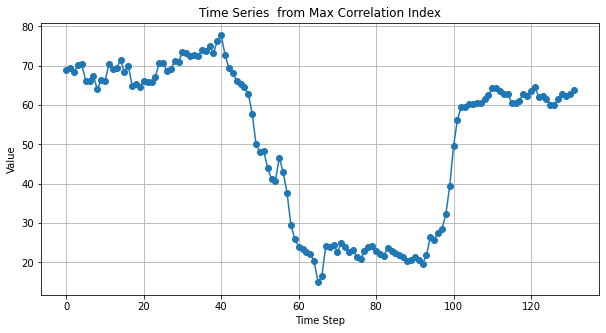

In [51]:
#Plot of data after the max correlation index
max_correlation_seq=context_window_data[0:]
#print(f"max_correlation_seq:{max_correlation_seq} index:{max_index}")
#print(f"context_data:{context_data}  max_correlation_seq:{max_correlation_seq}")
plt.figure(figsize=(10, 5))
plt.plot(max_correlation_seq, marker='o')
plt.title('Time Series  from Max Correlation Index')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show() 

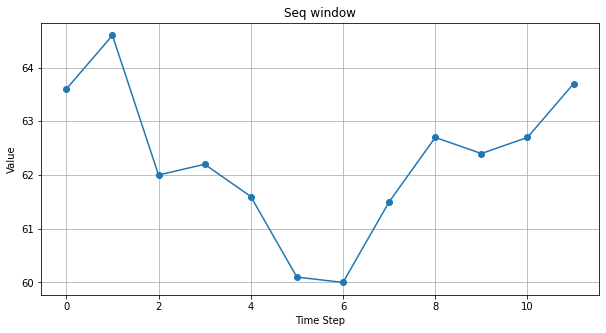

In [52]:
#Plot of sequence window data
plt.figure(figsize=(10, 5))
plt.plot(seq_data, marker='o')
plt.title('Seq window')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

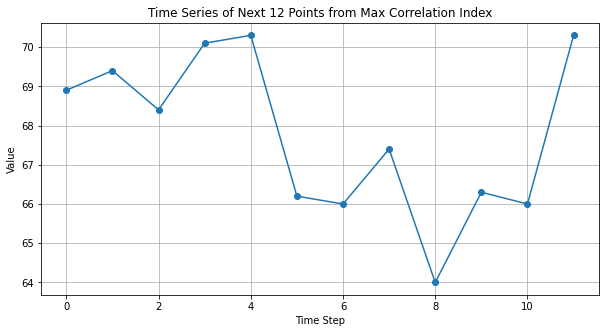

In [53]:
#plot of 12 sequences where max correlation index was found
plt.figure(figsize=(10, 5))
plt.plot(context_window_data[0:12], marker='o')
plt.title('Time Series of Next 12 Points from Max Correlation Index')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [54]:
context_window_data[0:12]

array([68.9, 69.4, 68.4, 70.1, 70.3, 66.2, 66. , 67.4, 64. , 66.3, 66. ,
       70.3])

In [55]:
#context_window_data[-12:]


In [56]:
#context_window_data

In [57]:
for epoch in tqdm(range(epochs)):
        model.train()
        for (batch_idx, (X,y)),(batch_idx_2,(X_attn)) in zip(enumerate(train_loader), enumerate(train_attention_loader)):
            pred=model(X,y,X_attn,training=True)
            #print(f"pred shape: {pred.shape}, attention_val shape: {attention_val.shape}")
            pred=pred[:,-horizon:,:]
            optimizer.zero_grad()
            loss=loss_fun(pred,y)
            loss.backward()
            optimizer.step()

        model.eval()

        with torch.no_grad():
          for (batch_idx, (X,y)), (batch_idx_2,(X_attn)) in zip(enumerate(valid_loader), enumerate(valid_attention_loader)):
              pred=model(X,y,X_attn,training=True)
              pred=pred[:,-horizon:,:]
              valid_loss=loss_fun(pred,y)
        #if epoch%10==0:
        print(f"epoch: {epoch} train loss:{loss} valid loss:{valid_loss} ")

 10%|█████████████▌                                                                                                                         | 1/10 [01:30<13:33, 90.43s/it]

epoch: 0 train loss:1411.5550537109375 valid loss:1549.714111328125 


 20%|███████████████████████████                                                                                                            | 2/10 [03:01<12:04, 90.58s/it]

epoch: 1 train loss:482.05511474609375 valid loss:509.40130615234375 


 30%|████████████████████████████████████████▏                                                                                             | 3/10 [05:35<13:57, 119.66s/it]

epoch: 2 train loss:193.63714599609375 valid loss:116.37632751464844 


 40%|█████████████████████████████████████████████████████▌                                                                                | 4/10 [08:02<13:02, 130.49s/it]

epoch: 3 train loss:160.019287109375 valid loss:76.6900405883789 


 50%|███████████████████████████████████████████████████████████████████                                                                   | 5/10 [10:17<11:00, 132.14s/it]

epoch: 4 train loss:168.26052856445312 valid loss:91.84226989746094 


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 6/10 [12:27<08:45, 131.30s/it]

epoch: 5 train loss:165.15325927734375 valid loss:103.96109771728516 


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7/10 [13:55<05:51, 117.22s/it]

epoch: 6 train loss:178.52294921875 valid loss:76.1949462890625 


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8/10 [15:22<03:35, 107.61s/it]

epoch: 7 train loss:157.2798614501953 valid loss:85.25849914550781 


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [16:48<01:40, 100.83s/it]

epoch: 8 train loss:152.97508239746094 valid loss:95.54521179199219 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [18:13<00:00, 109.31s/it]

epoch: 9 train loss:138.6077117919922 valid loss:94.18856811523438 


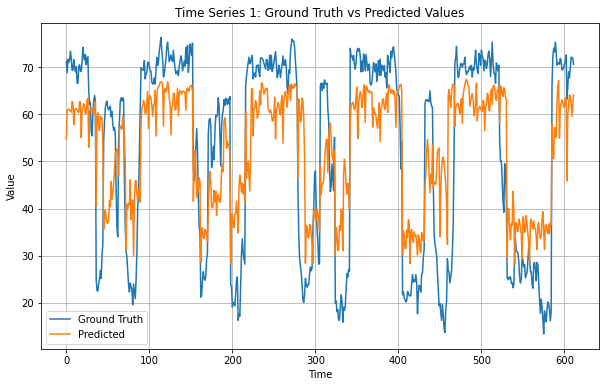

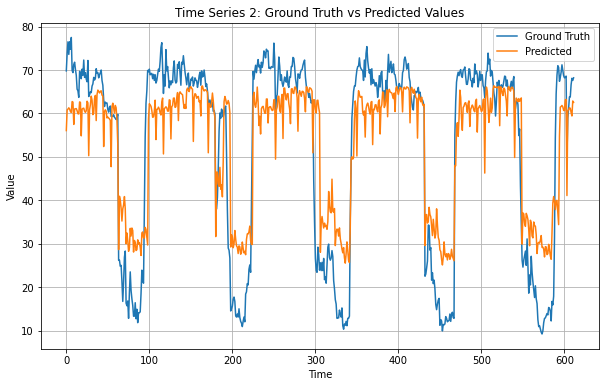

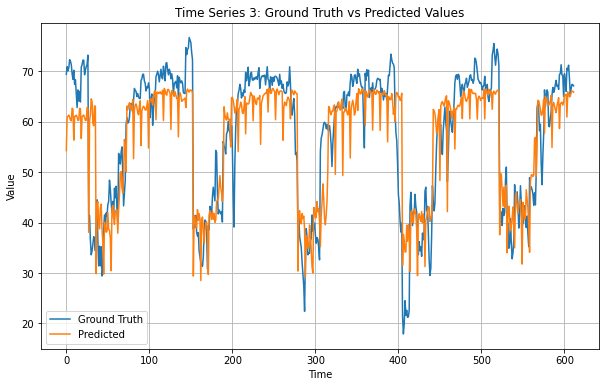

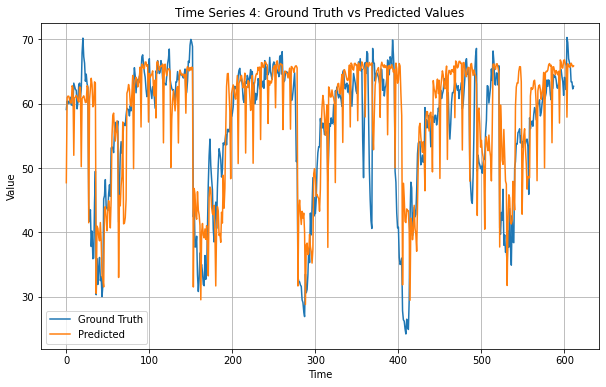

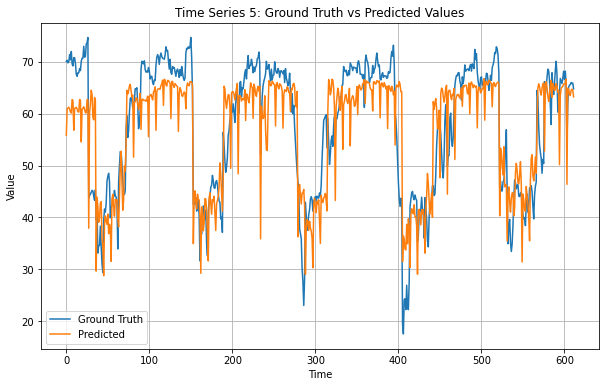

In [58]:
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]


for i in range(X_test.size(0)):
  curent_X_test=X_test[i,:,:,:]
  current_y_test=y_test[i,:,:,:]
  current_X_attention=X_test_attention[i,:,:,:]
  #print(f"current_X_test shape:{curent_X_test.shape} current_y_test:{current_y_test.shape} current_X_attention shape:{current_X_attention.shape}")
  pred=model(curent_X_test,current_y_test,current_X_attention,training=False)

  pred=pred[:,-horizon:,:]
  pred=pred.reshape(-1,1).detach().numpy()
  current_y_test=current_y_test.reshape(-1,1).detach().numpy()

  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))

  plt.figure(figsize=(10, 6))
  plt.plot(current_y_test, label='Ground Truth')
  plt.plot(pred, label='Predicted')
  plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
  plt.show()
  plt.close()



In [59]:
loss_val=torch.stack(loss,dim=0)
mean_loss=torch.mean(loss_val)
mean_loss

tensor(97.7486)

In [60]:
loss

[tensor(189.7841),
 tensor(132.9778),
 tensor(57.3818),
 tensor(54.8778),
 tensor(53.7215)]